In [1]:
import torch
import pandas as pd
import numpy as np
import os
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
%matplotlib inline

torch.set_printoptions(threshold=1000)

In [2]:
Dataset_dir = "../Cyclist_Detection/Dataset"

In [3]:
#Writing our Dataset class
class YoloPtDataset(torch.utils.data.Dataset):
    """Dataset with tensor format images and Yolo format labels"""

    def __init__(self,root_dir,data_type=None,transform=None):
        if data_type is None:
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a src file with the paths to all the images")
        elif data_type == 'train' or data_type == 'Train':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","train_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a train_src file with the paths to all the images")

        elif data_type == 'val' or data_type == 'Validate' or data_type == 'validate':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","val_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a val_src file with the paths to all the images")

        elif data_type == 'test' or data_type == 'Test':
            try:
                self.paths = pd.read_csv(os.path.join(root_dir,"src","test_src.csv"))
                self.paths.values.astype(str)
            except:
                raise TypeError("The directory doesn't have a test_src file with the paths to all the images")
        else:
            raise ValueError("Wrong argument has been passed through data_type, must be one of: train,test,val")



        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label_path = self.paths.iloc[idx,1:].values

        return torch.load(img_path),torch.load(label_path)

In [4]:
#Modyifying yolo formatted coordinates to (x_left,y_left,x_right,y_right)
def yolo_to_xy(yolo):
    _yolo = yolo.clone()
    w,h = yolo[:,2]/2,yolo[:,3]/2
    _yolo[:,0] = yolo[:,0]-w
    _yolo[:,1] = yolo[:,1]-h
    _yolo[:,2] = yolo[:,0]+w
    _yolo[:,3] = yolo[:,1]+h
    return _yolo

In [5]:
def xy_to_yolo(xy):
    if xy.shape[1] == 5:
        x1,y1,x2,y2 = xy[:,1],xy[:,2],xy[:,3],xy[:,4]
        cx = (x1 +x2)/2
        cy = (y1 + y2)/2
        w = x2 - x1
        h = y2 - y1

        return torch.stack((xy[:,0],cx,cy,w,h),axis=-1)

    elif xy.shape[1] == 4:
        x1,y1,x2,y2 = xy[:,0],xy[:,1],xy[:,2],xy[:,3]
        cx = (x1 +x2)/2
        cy = (y1 + y2)/2
        w = x2 - x1
        h = y2 - y1

        return torch.stack((cx,cy,w,h),axis=-1)

    else:
        raise ValueError(f'Wrong input shape:{xy.shape},takes [i,4] or [i,5]')



In [6]:
print(xy_to_yolo(yolo_to_xy(torch.tensor([[0.5,0.5,1,1]]))))
print(xy_to_yolo(yolo_to_xy(torch.tensor([[0.5,0.5,1,1],[0.5,0.5,1,1]]))))

tensor([[0.5000, 0.5000, 1.0000, 1.0000]])
tensor([[0.5000, 0.5000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000]])


In [7]:
#Displaying a single image with bounding boxes
def Display_yolo(data,colour='green',width = 5,dtype='yolo'):

    img, label = data[0],data[1]
    resolution = img.size()[1:3]
    trans = torchvision.transforms.ToPILImage()
    img = trans(img)
    draw = ImageDraw.Draw(img)

    #Removing negative padding
    for i in range(len(label)):
        if label[i][0] == -1:
            label = label[0:i]
            break

    #Transforming to bounding box xy coordinates
    if dtype == 'yolo':
        label = yolo_to_xy(label[:,1:5])
    else:
        label = label[:,1:5]
    label[:,0],label[:,2] = label[:,0]*resolution[1],label[:,2]*resolution[1]
    label[:,1],label[:,3] = label[:,1]*resolution[0],label[:,3]*resolution[0]
    label = label.tolist()

    #Re-calculates the yolo format to top-left and bottom right points
    for i in label:
        draw.rectangle(i,outline=colour,width=4)

    display(img)

In [8]:
train = YoloPtDataset(Dataset_dir,data_type='train')
val = YoloPtDataset(Dataset_dir,data_type='val')
test = YoloPtDataset(Dataset_dir,data_type='test')
train_iter = torch.utils.data.DataLoader(train,batch_size=3,shuffle=False)
val_iter = torch.utils.data.DataLoader(val,batch_size=len(val),shuffle=False)
test_iter = torch.utils.data.DataLoader(test,batch_size=len(test),shuffle=False)

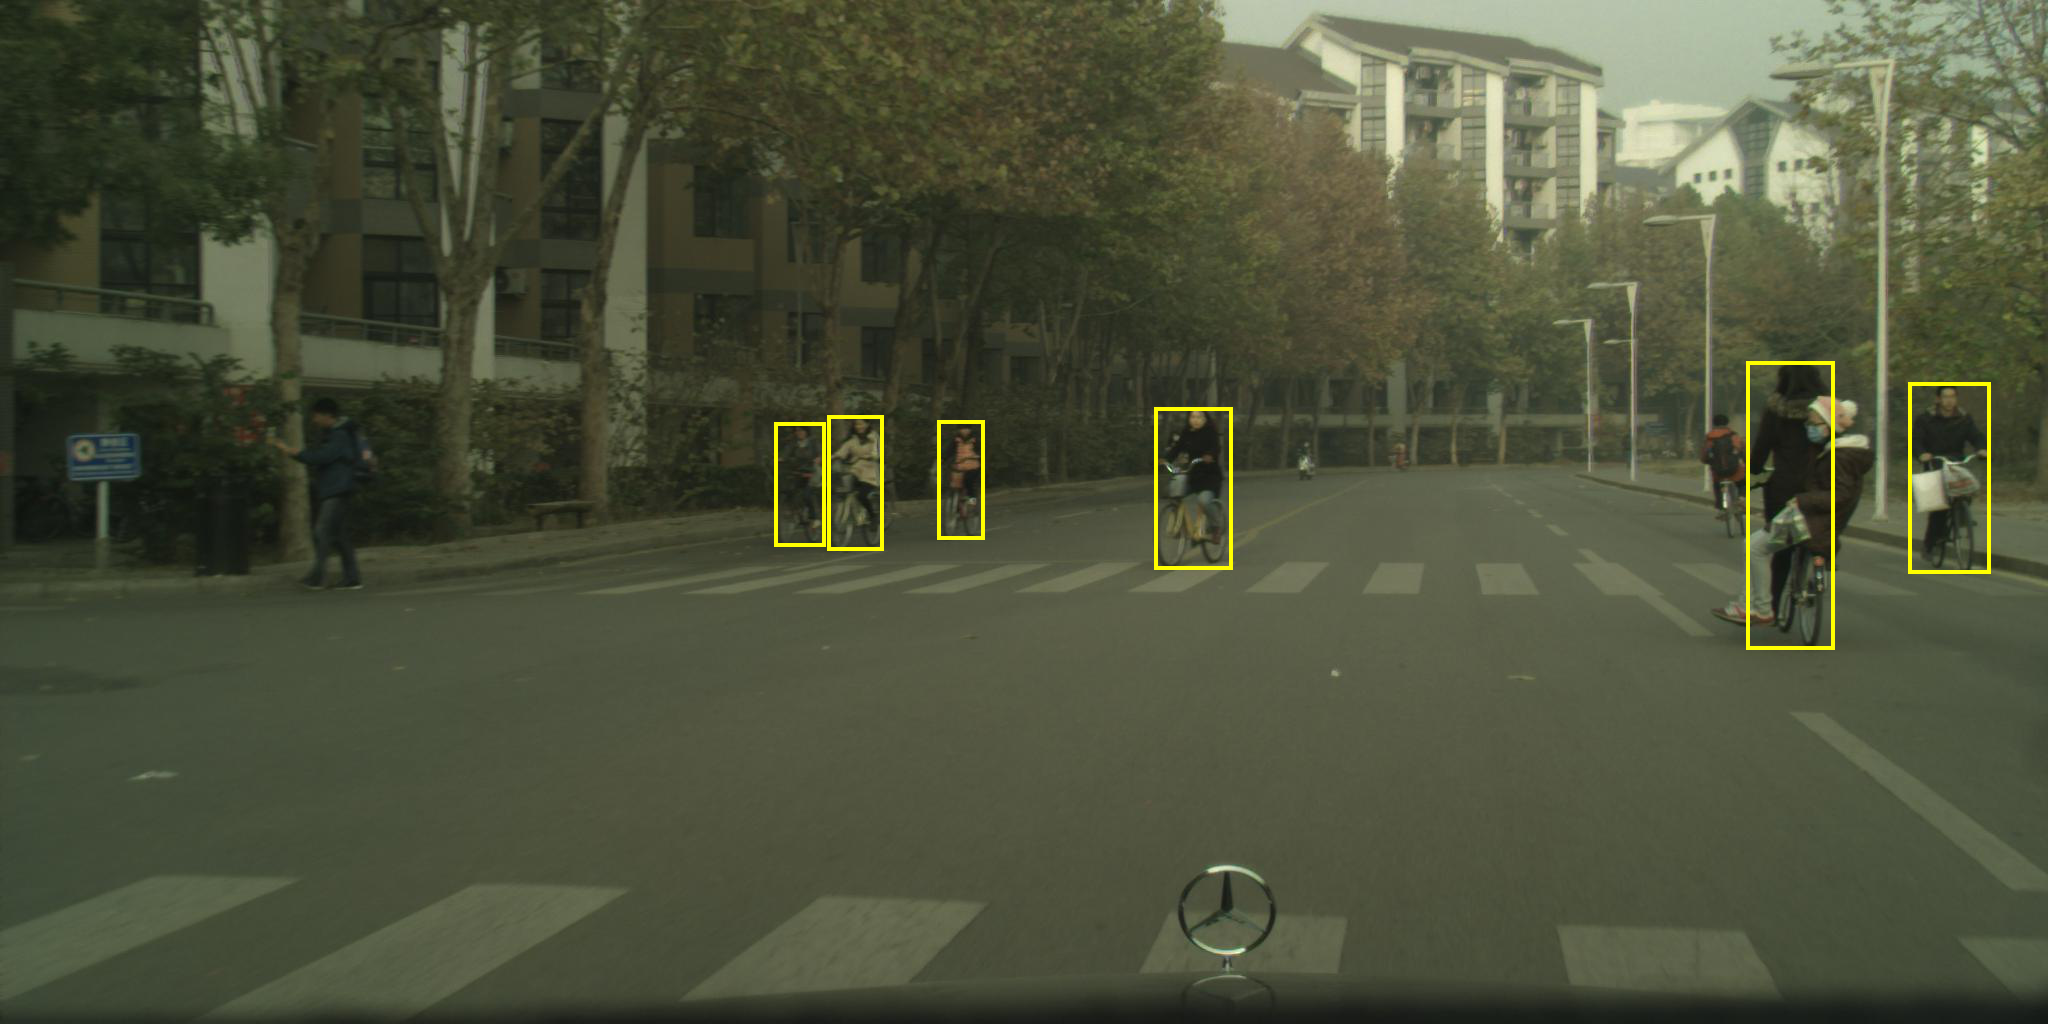

In [9]:
Display_yolo(train[402],colour='yellow')

In [10]:
next(iter(train_iter))

[tensor([[[[27, 26, 25,  ..., 22, 21, 21],
           [27, 26, 25,  ..., 23, 22, 22],
           [26, 26, 25,  ..., 25, 25, 25],
           ...,
           [43, 43, 43,  ..., 19, 19, 19],
           [43, 42, 42,  ..., 19, 19, 19],
           [42, 42, 42,  ..., 19, 19, 19]],
 
          [[35, 34, 33,  ..., 25, 24, 24],
           [35, 34, 33,  ..., 26, 25, 25],
           [34, 34, 33,  ..., 28, 28, 28],
           ...,
           [51, 51, 51,  ..., 24, 24, 24],
           [51, 50, 50,  ..., 24, 24, 24],
           [50, 50, 50,  ..., 24, 24, 24]],
 
          [[24, 23, 22,  ..., 14, 13, 13],
           [24, 23, 22,  ..., 15, 14, 14],
           [23, 23, 22,  ..., 17, 17, 17],
           ...,
           [36, 36, 36,  ..., 18, 18, 18],
           [36, 35, 35,  ..., 18, 18, 18],
           [35, 35, 35,  ..., 18, 18, 18]]],
 
 
         [[[31, 30, 28,  ..., 23, 22, 21],
           [29, 28, 27,  ..., 26, 26, 26],
           [28, 27, 26,  ..., 28, 28, 29],
           ...,
           [42, 42, 4

In [11]:
def Intersection_Over_Union(anchors,bounding_boxes,ltype='yolo'):
    if ltype == 'yolo':
        if bounding_boxes.shape[1] == 5:
            b1 = yolo_to_xy(anchors)
            b2 = yolo_to_xy(bounding_boxes[:,1:5])
            bounding_areas = bounding_boxes[:,3]*bounding_boxes[:,4]
        elif bounding_boxes.shape[1] == 4:
            b1 = yolo_to_xy(anchors)
            b2 = yolo_to_xy(bounding_boxes)
            bounding_areas = bounding_boxes[:,2]*bounding_boxes[:,3]
        else:
            raise ValueError(f'Wrong shape of input {bounding_boxes.shape}, takes input [i,5] or [i,4]')

    else:
        b1 = anchors.clone()
        b2 = bounding_boxes[:,1:5]


    inter_upperlefts = torch.max(b1[:, None, :2], b2[:, :2])
    inter_lowerrights = torch.min(b1[:, None, 2:], b2[:, 2:])



    inters = (inter_lowerrights-inter_upperlefts).clamp(min=0)
    intersection = inters[:, :, 0] * inters[:, :, 1]

    anchor_areas = anchors[:,2]*anchors[:,3]


    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = anchor_areas[:, None] + bounding_areas - inter_areas

    return inter_areas/union_areas

In [12]:
temp_1 = torch.tensor([[0.25,0.25,0.5,0.5],[0.5,0.5,1,1]])
temp_2 = torch.tensor([[0,0.5,0.5,0.5,0.5],[0,0.5,0.5,1,1]])
print(Intersection_Over_Union(temp_1,temp_2))

tensor([[0.1429, 0.2500],
        [0.2500, 1.0000]])


In [13]:
def assign_anchor_to_bbox(anchors,ground_truth,device='cpu',iou_treshold = 0.7):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = Intersection_Over_Union(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                              device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [14]:
temp_1 = torch.tensor([[0.25,0.25,0.5,0.5],[0.5,0.5,1,1]])
temp_2 = torch.tensor([[0.5,0.5,0.5,0.5],[0.5,0.5,1,1]])
print(assign_anchor_to_bbox(temp_1,temp_2,iou_treshold=0.20))

tensor([0, 1])


In [15]:
def calc_offsets(anchors,bounding_boxes,eps=1e-6):
    offset_xy = 10 * (bounding_boxes[:, :2] - anchors[:, :2]) / anchors[:, 2:]
    offset_wh = 5 * torch.log(eps + bounding_boxes[:, 2:] / anchors[:, 2:])
    return torch.cat([offset_xy, offset_wh], axis=1)

In [16]:
print(calc_offsets(temp_1,temp_2[:,1:5]))

tensor([[5.0000e+00, 5.0000e+00, 4.7684e-06, 4.7684e-06],
        [0.0000e+00, 5.0000e+00, 4.7684e-06, 4.7684e-06]])


In [36]:
def multibox_target(anchors, labels,iou_threshold = 0.5):
    """Label anchor boxes using ground-truth bounding boxes."""

    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]

    for i in range(batch_size):

        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            anchors,label[:,1:], device,iou_treshold=iou_threshold)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)

        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)

        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        # Offset transformation
        offset = calc_offsets(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)

    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [37]:
multibox_target(temp_1,next(iter(train_iter))[1],iou_threshold=0.5)

(tensor([[  1.6016,   3.9746, -12.0484,  -6.9707,  -5.0000,  -5.0000, -69.0776,
          -69.0776],
         [  2.5439,   3.8867, -12.1030,  -7.1715,  -5.0000,  -5.0000, -69.0776,
          -69.0776],
         [  3.2031,   3.8281, -13.4148,  -7.4236,  -5.0000,  -5.0000, -69.0776,
          -69.0776]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]),
 tensor([[1, 0],
         [1, 0],
         [1, 0]]))

In [46]:
#Examples from d2l:
ground_truth_ = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors_ = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])
ground_truth_ = xy_to_yolo(ground_truth_)
anchors_ = xy_to_yolo(anchors_)

In [50]:
multibox_target(anchors_.unsqueeze(dim=0),ground_truth_.unsqueeze(dim=0),iou_threshold=1)

(tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
           1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
           1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

In [51]:
#Adjusting anchors' position based on their predicted offsets
def offset_boxes(anchors,offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    pred_bbox_xy = (offset_preds[:, :2] * anchors[:, 2:] / 10) + anchors[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anchors[:, 2:]
    return torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)

In [52]:
#Non-maximum-suppression
def nms(boxes,scores,iou_treshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = Intersection_Over_Union(boxes[i, :].reshape(-1, 4),
                    boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_treshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

def non_maximum_suppression(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):

        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_boxes(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               out.append(pred_info),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
    return torch.stack(out)

In [22]:
##Code from d2l, to re-write for yolo

In [23]:
#Generating priors
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis
    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
        in_height * in_width, 1) / 2
    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                           dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [24]:
#Functions for SSD
def cls_predictor(num_inputs,priors,classes):
    return nn.Conv2d(num_inputs,priors*(classes+1),kernel_size=3,padding=1)

def offset_predictor(num_inputs,priors):
    return nn.Conv2d(num_inputs,priors*4,kernel_size=3,padding=1)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_pred(pred):
    return torch.cat([flatten_pred(p) for p in pred], dim=1)

In [25]:
#Building blocks of SSD
def SSD_Conv_Block(num_inputs,num_outputs,convolutions=2,downsample=2):
    blk = []
    for _ in range(convolutions):
        blk.append(nn.Conv2d(num_inputs,num_outputs,kernel_size=3,padding=1))
        blk.append(nn.BatchNorm2d(num_outputs))
        blk.append(nn.ReLU())
        num_inputs = num_outputs
    blk.append(nn.MaxPool2d(downsample))
    return nn.Sequential(*blk)


def SSD_Base_Block(channels):
    if not isinstance(channels,list):
        raise TypeError("channels argument must be list of channels")

    blk = []
    for i in range(len(channels)-1):
        blk.append(SSD_Conv_Block(channels[i],channels[i+1]))
    return nn.Sequential(*blk)

def SSD_Block_Forward(data,blk,sizes,ratios,cls_predictor,offset_predictor):
    Y = blk(data)
    priors = multibox_prior(Y,sizes=sizes,ratios=ratios)
    cls_preds = cls_predictor(Y)
    offset_preds = offset_predictor(Y)
    return Y,priors, cls_preds, offset_preds

In [26]:
class SSD(nn.Module):
    def __init__(self,classes,base_channels,remaining_channels,sizes,ratios,**kwargs):
        super(SSD,self).__init__(**kwargs)

        if not isinstance(base_channels,list):
            raise TypeError("base_channels argument must be list of channels")

        if not isinstance(remaining_channels,list):
            raise TypeError("remaining_channels argument must be list of channels")

        self.remaining_channels = remaining_channels
        self.sizes = sizes
        self.ratios = ratios
        self.priors = len(self.sizes[0]) + len(self.ratios[0]) - 1

        if not len(self.remaining_channels) == self.priors+1:
            raise TypeError(f'The amount of priors {self.priors+1}, does not match amount of layers {len(self.remaining_channels)}')


        self.classes = classes
        self.base_channels = base_channels



        self.blk_0 = SSD_Base_Block(self.base_channels)
        self.cls_0 = cls_predictor(self.base_channels[-1],self.priors,self.classes)
        self.ofs_0 = offset_predictor(self.base_channels[-1],self.priors)


        for i in range(len(self.remaining_channels)):

            if i == len(self.remaining_channels)-2:

                setattr(self,f'blk_{i+1}',nn.AdaptiveMaxPool2d((1,1)))
                setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
                setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))
                self.pred_layers = i+2

                break


            setattr(self,f'blk_{i+1}',SSD_Conv_Block(self.remaining_channels[i],self.remaining_channels[i+1]))
            setattr(self,f'cls_{i+1}',cls_predictor(self.remaining_channels[i+1],self.priors,self.classes))
            setattr(self,f'ofs_{i+1}',offset_predictor(self.remaining_channels[i+1],self.priors))

    def forward(self,X):
        anchors, cls_preds,ofs_preds = [None]*self.pred_layers, [None]*self.pred_layers,[None]*self.pred_layers

        for i in range(self.pred_layers):
            X, anchors[i],cls_preds[i],ofs_preds[i] = SSD_Block_Forward(X,getattr(self,f'blk_{i}'),self.sizes[i],self.ratios[i],getattr(self,f'cls_{i}'),getattr(self,f'ofs_{i}'))

        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_pred(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0],-1,self.classes +1)
        ofs_preds = concat_pred(ofs_preds)
        return anchors,cls_preds,ofs_preds


In [27]:
#Temp
temp_sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
temp_ratios = [[1, 2, 0.5]] * 5
temp_net = SSD(1,[3,16,32,64],[64,128,128,128,128],temp_sizes,temp_ratios)

temp_net.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('blk_0',
               Sequential(
                 (0): Sequential(
                   (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                   (2): ReLU()
                   (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                   (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                   (5): ReLU()
                   (6): MaxPool2d(kernel_size=2, stride=2, padding=

In [28]:
temp_img, temp_label = next(iter(train_iter))
temp_img, temp_label = temp_img.type(torch.float32),temp_label.type(torch.float32)
output_anchors, output_cls_preds, output_ofs_preds = temp_net(temp_img)

C:\Users\48510\anaconda3\envs\torchenv\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [29]:
output_anchors.shape

torch.Size([1, 174084, 4])

In [30]:
output_cls_preds.shape

torch.Size([3, 174084, 2])

In [31]:
output_ofs_preds.shape

torch.Size([3, 696336])

In [32]:
temp_label

tensor([[[ 0.0000,  0.3301,  0.4487,  0.0449,  0.1240],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.3772,  0.4443,  0.0444,  0.1191],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000, 